# Capstone 3 - Pre-Processing and Training

### Table of contents
* [1.0 Intorduction](#1.0)
    * [1.1 Purpose](#1.1)
    * [1.2 Approach](#1.2)
* [2.0 Load the data](#2.0)
    * [2.1 Imports](#2.1)
    * [2.2 Load data](#2.2)
    * [2.3 Adjust elements of the data for EDA suitability](#2.3)
* [3.0 Exploring the data](#3.0)
    * [3.1 Selecting one time series to view](#3.1)
    * [3.2 Inspecting missing data](#3.2)
    * [3.3 Imputing missing data](#3.3)
    * [3.4 Updating missing information](#3.4)
* [4.0 Visualizing sales data](#4.0)
    * [4.1 Sales by year for entire Favorita organization](#4.1)
    * [4.2 Sales by month for entire Favorita organization](#4.2)
    * [4.3 Sales by year for each grouping category](#4.3)
    * [4.4 Daily sales trends](#4.4)
* [5.0 Visualizing non-sales data](#5.0)
    * [5.1 Visualizing oil data](#5.1)
    * [5.2 Visualizing transaction data](#5.2)
    * [5.3 Relationships between time series](#5.3)
* [6.0 Decomposing the time series](#6.0)
    * [6.1 Dickey-Fuller test](#6.1)
    * [6.2 Seasonal decomposition](#6.2)
* [7.0 Output and Summary](#7.0)

### 1.0 Introduction: <a id='1.0'></a>

In order to stay in business, commercial grocery stores must offer prices that are commensurate with competitors, offer deals to entice customers, and accurately predict which products, and the quantity of those products, to keep in stock. These considerations are confounded by the effect of both seasonal and regional trends.

Especially for grocers, the consequences of poor inventory management are dire. Perishable items like fruits and vegetables can rot before selling if they are overstocked. Conversely, many locations do not have the real estate or capability to store overstocked, low-demand items that are not selling. According to Retail Wire, overstocking costs the average retailer 3.2% in lost revenue, while understocking items can cost 4.1%. A review of the data has shown that overstocks are costing retailers \\$123.4 billion every year, and understocks remove another \\$129.5 billion from net inflows. [1]

#### 1.1 Purpose<a id='1.1'></a>

Using Kaggle data available from Favorita grocery stores located in Ecuador [2], we will assess and predict sales of available items using time series analysis. There are multiple datasets that will require some data to be merged. We have information on transactions, stores, regions, holidays, and even oil pricing.

[1] https://www.retailwire.com/discussion/retailers-suffer-the-high-cost-of-overstocks-and-out-of-stocks/

[2] Alexis Cook, DanB, inversion, Ryan Holbrook. (2021). Store Sales - Time Series Forecasting. Kaggle. https://kaggle.com/competitions/store-sales-time-series-forecasting


#### 1.2 Approach<a id='1.2'></a>

We will use machine learning time series analysis to forecast sales of different types of items across dozens of stores. This will allow Favorita to become more efficient with its distribution of resources, and more likely to attract customers to purchase certain products at certain times. This analysis can also inform the company of the best times to offer discounts, whether to stock up on certain items, and knowledge of general market trends.


### 2.0 Load our cleaned data<a id='2.0'></a>

#### 2.1 Imports<a id='2.1'></a>

In [1]:
# import needed modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
from matplotlib.dates import DateFormatter
import seaborn as sns
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.colors import BoundaryNorm, ListedColormap
from datetime import timedelta, datetime
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from numpy.polynomial.polynomial import polyfit
from scipy.stats import pearsonr
from matplotlib.pyplot import figure
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from pandas.plotting import autocorrelation_plot

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
"""
Author: Kishan Manani
License: BSD-3 Clause
An implementation of MSTL [1], an algorithm for time series decomposition when
there are multiple seasonal components.
This implementation has the following differences with the original algorithm:
- Missing data must be handled outside of this class.
- The algorithm proposed in the paper handles a case when there is no
seasonality. This implementation assumes that there is at least one seasonal
component.
[1] K. Bandura, R.J. Hyndman, and C. Bergmeir (2021)
MSTL: A Seasonal-Trend Decomposition Algorithm for Time Series with Multiple
Seasonal Patterns
https://arxiv.org/pdf/2107.13462.pdf
"""
from typing import Dict, Optional, Sequence, Tuple, Union
import warnings

import numpy as np
import pandas as pd
from scipy.stats import boxcox

#from statsmodels.tools.typing import ArrayLike1D
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.tsatools import freq_to_period


class MSTL:
    """
    MSTL(endog, periods=None, windows=None, lmbda=None, iterate=2,
         stl_kwargs=None)
    Season-Trend decomposition using LOESS for multiple seasonalities.
    Parameters
    ----------
    endog : array_like
        Data to be decomposed. Must be squeezable to 1-d.
    periods : {int, array_like, None}, optional
        Periodicity of the seasonal components. If None and endog is a pandas
        Series or DataFrame, attempts to determine from endog. If endog is a
        ndarray, periods must be provided.
    windows : {int, array_like, None}, optional
        Length of the seasonal smoothers for each corresponding period.
        Must be an odd integer, and should normally be >= 7 (default). If None
        then default values determined using 7 + 4 * np.arange(1, n + 1, 1)
        where n is number of seasonal components.
    lmbda : {float, str, None}, optional
        The lambda parameter for the Box-Cox transform to be applied to `endog`
        prior to decomposition. If None, no transform is applied. If "auto", a
        value will be estimated that maximizes the log-likelihood function.
    iterate : int, optional
        Number of iterations to use to refine the seasonal component.
    stl_kwargs: dict, optional
        Arguments to pass to STL.
    See Also
    --------
    statsmodels.tsa.seasonal.STL
    References
    ----------
    .. [1] K. Bandura, R.J. Hyndman, and C. Bergmeir (2021)
        MSTL: A Seasonal-Trend Decomposition Algorithm for Time Series with
        Multiple Seasonal Patterns. arXiv preprint arXiv:2107.13462.
    Examples
    --------
    Start by creating a toy dataset with hourly frequency and multiple seasonal
    components.
    >>> import numpy as np
    >>> import matplotlib.pyplot as plt
    >>> import pandas as pd
    >>> pd.plotting.register_matplotlib_converters()
    >>> np.random.seed(0)
    >>> t = np.arange(1, 1000)
    >>> trend = 0.0001 * t ** 2 + 100
    >>> daily_seasonality = 5 * np.sin(2 * np.pi * t / 24)
    >>> weekly_seasonality = 10 * np.sin(2 * np.pi * t / (24 * 7))
    >>> noise = np.random.randn(len(t))
    >>> y = trend + daily_seasonality + weekly_seasonality + noise
    >>> index = pd.date_range(start='2000-01-01', periods=len(t), freq='H')
    >>> data = pd.DataFrame(data=y, index=index)
    Use MSTL to decompose the time series into two seasonal components
    with periods 24 (daily seasonality) and 24*7 (weekly seasonality).
    >>> from statsmodels.tsa.seasonal import MSTL
    >>> res = MSTL(data, periods=(24, 24*7)).fit()
    >>> res.plot()
    >>> plt.tight_layout()
    >>> plt.show()
    .. plot:: plots/mstl_plot.py
    """

    def __init__(
        self,
        endog,
        *,
        periods: Optional[Union[int, Sequence[int]]] = None,
        windows: Optional[Union[int, Sequence[int]]] = None,
        lmbda: Optional[Union[float, str]] = None,
        iterate: int = 2,
        stl_kwargs: Optional[Dict[str, Union[int, bool, None]]] = None,
    ):
        self.endog = endog
        self._y = self._to_1d_array(endog)
        self.nobs = self._y.shape[0]
        self.lmbda = lmbda
        self.periods, self.windows = self._process_periods_and_windows(
            periods, windows
        )
        self.iterate = iterate
        self._stl_kwargs = self._remove_overloaded_stl_kwargs(
            stl_kwargs if stl_kwargs else {}
        )

    def fit(self):
        """
        Estimate a trend component, multiple seasonal components, and a
        residual component.
        Returns
        -------
        DecomposeResult
            Estimation results.
        """
        num_seasons = len(self.periods)
        iterate = 1 if num_seasons == 1 else self.iterate

        # Box Cox
        if self.lmbda == "auto":
            y, lmbda = boxcox(self._y, lmbda=None)
            self.est_lmbda = lmbda
        elif self.lmbda:
            y = boxcox(self._y, lmbda=self.lmbda)
        else:
            y = self._y

        # Get STL fit params
        stl_inner_iter = self._stl_kwargs.pop("inner_iter", None)
        stl_outer_iter = self._stl_kwargs.pop("outer_iter", None)

        # Iterate over each seasonal component to extract seasonalities
        seasonal = np.zeros(shape=(num_seasons, self.nobs))
        deseas = y
        for _ in range(iterate):
            for i in range(num_seasons):
                deseas = deseas + seasonal[i]
                res = STL(
                    endog=deseas,
                    period=self.periods[i],
                    seasonal=self.windows[i],
                    **self._stl_kwargs,
                ).fit(inner_iter=stl_inner_iter, outer_iter=stl_outer_iter)
                seasonal[i] = res.seasonal
                deseas = deseas - seasonal[i]

        seasonal = np.squeeze(seasonal.T)
        trend = res.trend
        rw = res.weights
        resid = deseas - trend

        # Return pandas if endog is pandas
        if isinstance(self.endog, (pd.Series, pd.DataFrame)):
            index = self.endog.index
            y = pd.Series(y, index=index, name="observed")
            trend = pd.Series(trend, index=index, name="trend")
            resid = pd.Series(resid, index=index, name="resid")
            rw = pd.Series(rw, index=index, name="robust_weight")
            cols = [f"seasonal_{period}" for period in self.periods]
            if seasonal.ndim == 1:
                seasonal = pd.Series(seasonal, index=index, name="seasonal")
            else:
                seasonal = pd.DataFrame(seasonal, index=index, columns=cols)

        # Avoid circular imports
        from statsmodels.tsa.seasonal import DecomposeResult

        return DecomposeResult(y, seasonal, trend, resid, rw)

    def __str__(self):
        return (
            "MSTL(endog,"
            f" periods={self.periods},"
            f" windows={self.windows},"
            f" lmbda={self.lmbda},"
            f" iterate={self.iterate})"
        )

    def _process_periods_and_windows(
        self,
        periods: Union[int, Sequence[int], None],
        windows: Union[int, Sequence[int], None],
    ) -> Tuple[Sequence[int], Sequence[int]]:
        periods = self._process_periods(periods)

        if windows:
            windows = self._process_windows(windows, num_seasons=len(periods))
            periods, windows = self._sort_periods_and_windows(periods, windows)
        else:
            windows = self._process_windows(windows, num_seasons=len(periods))
            periods = sorted(periods)

        if len(periods) != len(windows):
            raise ValueError("Periods and windows must have same length")

        # Remove long periods from decomposition
        if any(period >= self.nobs / 2 for period in periods):
            warnings.warn(
                "A period(s) is larger than half the length of time series."
                " Removing these period(s)."
            )
            periods = tuple(
                period for period in periods if period < self.nobs / 2
            )
            windows = windows[: len(periods)]

        return periods, windows

    def _process_periods(
        self, periods: Union[int, Sequence[int], None]
    ) -> Sequence[int]:
        if periods is None:
            periods = (self._infer_period(),)
        elif isinstance(periods, int):
            periods = (periods,)
        else:
            pass
        return periods

    def _process_windows(
        self,
        windows: Union[int, Sequence[int], None],
        num_seasons: int,
    ) -> Sequence[int]:
        if windows is None:
            windows = self._default_seasonal_windows(num_seasons)
        elif isinstance(windows, int):
            windows = (windows,)
        else:
            pass
        return windows

    def _infer_period(self) -> int:
        freq = None
        if isinstance(self.endog, (pd.Series, pd.DataFrame)):
            freq = getattr(self.endog.index, "inferred_freq", None)
        if freq is None:
            raise ValueError("Unable to determine period from endog")
        period = freq_to_period(freq)
        return period

    @staticmethod
    def _sort_periods_and_windows(
        periods, windows
    ) -> Tuple[Sequence[int], Sequence[int]]:
        if len(periods) != len(windows):
            raise ValueError("Periods and windows must have same length")
        periods, windows = zip(*sorted(zip(periods, windows)))
        return periods, windows

    @staticmethod
    def _remove_overloaded_stl_kwargs(stl_kwargs: Dict) -> Dict:
        args = ["endog", "period", "seasonal"]
        for arg in args:
            stl_kwargs.pop(arg, None)
        return stl_kwargs

    @staticmethod
    def _default_seasonal_windows(n: int) -> Sequence[int]:
        return tuple(7 + 4 * i for i in range(1, n + 1))  # See [1]

    @staticmethod
    def _to_1d_array(x):
        y = np.ascontiguousarray(np.squeeze(np.asarray(x)), dtype=np.double)
        if y.ndim != 1:
            raise ValueError("y must be a 1d array")
        return y

#### 2.2 Load data<a id='2.2'></a>

In [3]:
df = pd.read_csv('./favorita_data.csv')

In [4]:
df

,Unnamed: 0,store_nbr,family,sales,onpromotion,city,state,type,cluster,local_holiday,regional_holiday,national_holiday,transactions,dcoilwtico
0,2013-01-01,1,AUTOMOTIVE,0.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,1.0,0.0,93.14
1,2013-01-02,1,AUTOMOTIVE,2.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,0.0,2111.0,93.14
2,2013-01-03,1,AUTOMOTIVE,3.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,0.0,1833.0,92.97
3,2013-01-04,1,AUTOMOTIVE,3.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,0.0,1863.0,93.12
4,2013-01-05,1,AUTOMOTIVE,5.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,1.0,1509.0,93.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008011,2017-08-11,9,SEAFOOD,23.831000,0.0,Quito,Pichincha,B,6,0.0,0.0,1.0,1848.0,48.81
3008012,2017-08-12,9,SEAFOOD,16.859001,4.0,Quito,Pichincha,B,6,0.0,0.0,0.0,1920.0,48.81
3008013,2017-08-13,9,SEAFOOD,20.000000,0.0,Quito,Pichincha,B,6,0.0,0.0,0.0,1745.0,48.81
3008014,2017-08-14,9,SEAFOOD,17.000000,0.0,Quito,Pichincha,B,6,0.0,0.0,0.0,1971.0,47.59


In [5]:

df = df.rename(columns={'Unnamed: 0':'date'})
df['date'] = pd.to_datetime(df["date"])
df=df.set_index(df.columns[0])
df

,store_nbr,family,sales,onpromotion,city,state,type,cluster,local_holiday,regional_holiday,national_holiday,transactions,dcoilwtico
date,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,1.0,0.0,93.14
2013-01-02,1,AUTOMOTIVE,2.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,0.0,2111.0,93.14
2013-01-03,1,AUTOMOTIVE,3.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,0.0,1833.0,92.97
2013-01-04,1,AUTOMOTIVE,3.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,0.0,1863.0,93.12
2013-01-05,1,AUTOMOTIVE,5.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,1.0,1509.0,93.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,9,SEAFOOD,23.831000,0.0,Quito,Pichincha,B,6,0.0,0.0,1.0,1848.0,48.81
2017-08-12,9,SEAFOOD,16.859001,4.0,Quito,Pichincha,B,6,0.0,0.0,0.0,1920.0,48.81
2017-08-13,9,SEAFOOD,20.000000,0.0,Quito,Pichincha,B,6,0.0,0.0,0.0,1745.0,48.81


The store with the highest sales is Store 44 and the product family with the highest sales is 'GROCERY I'

In [6]:
grocI44 =  df[(df['family']=='GROCERY_I')&(df['store_nbr']==44)]

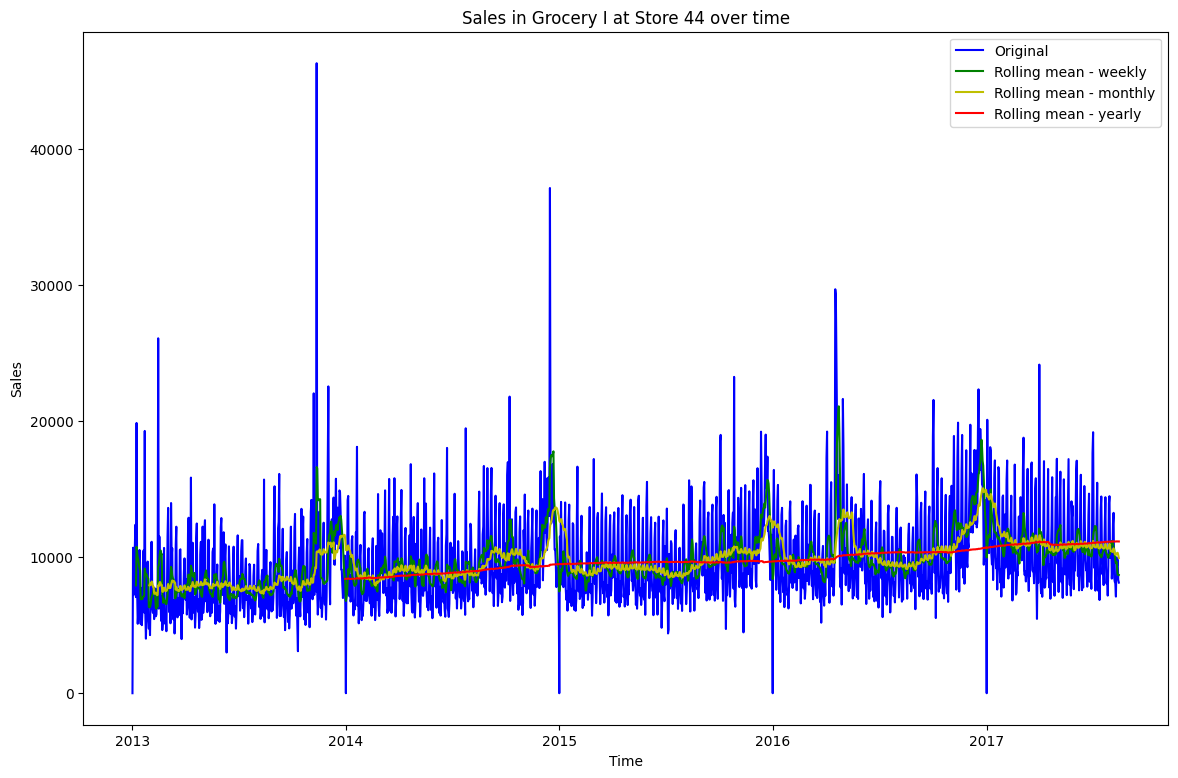

In [95]:
figure(figsize=(14,9), dpi=100)
plt.plot(grocI44['sales'],color='b', label='Original')
plt.plot(grocI44['sales'].rolling(7).mean(),color='g', label='Rolling mean - weekly')
plt.plot(grocI44['sales'].rolling(30).mean(),color='y', label='Rolling mean - monthly')

plt.plot(grocI44['sales'].rolling(365).mean(),color='r', label='Rolling mean - yearly')

plt.legend()
plt.title("Sales in Grocery I at Store 44 over time")
plt.xlabel('Time')
plt.ylabel('Sales')
plt.show()

Load testing data

In [96]:
df_testing = pd.read_csv('./test.csv')

In [97]:
df_testing

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [98]:

df_testing = df_testing.drop(columns=('id'))
df_testing['date'] = pd.to_datetime(df_testing["date"])
df_testing=df_testing.set_index(df_testing.columns[0])
df_testing

,store_nbr,family,onpromotion
date,,,
2017-08-16,1,AUTOMOTIVE,0
2017-08-16,1,BABY CARE,0
2017-08-16,1,BEAUTY,2
2017-08-16,1,BEVERAGES,20
2017-08-16,1,BOOKS,0
...,...,...,...
2017-08-31,9,POULTRY,1
2017-08-31,9,PREPARED FOODS,0
2017-08-31,9,PRODUCE,1


### 3.0 Stationarity and differencing

A stationary time series is one whose statistical properties do not depend on the time at which the series is observed.16 Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time.

Some cases can be confusing — a time series with cyclic behaviour (but with no trend or seasonality) is stationary. This is because the cycles are not of a fixed length, so before we observe the series we cannot be sure where the peaks and troughs of the cycles will be.

In general, a stationary time series will have no predictable patterns in the long-term. 

Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.

As well as the time plot of the data, the ACF plot is also useful for identifying non-stationary time series. For a stationary time series, the ACF will drop to zero relatively quickly, while the ACF of non-stationary data decreases slowly. 

#### 3.1 Base Autocorrelation

We can start the process of determining whether and how to difference the data by visualizing the unmodified ACF and PACF.

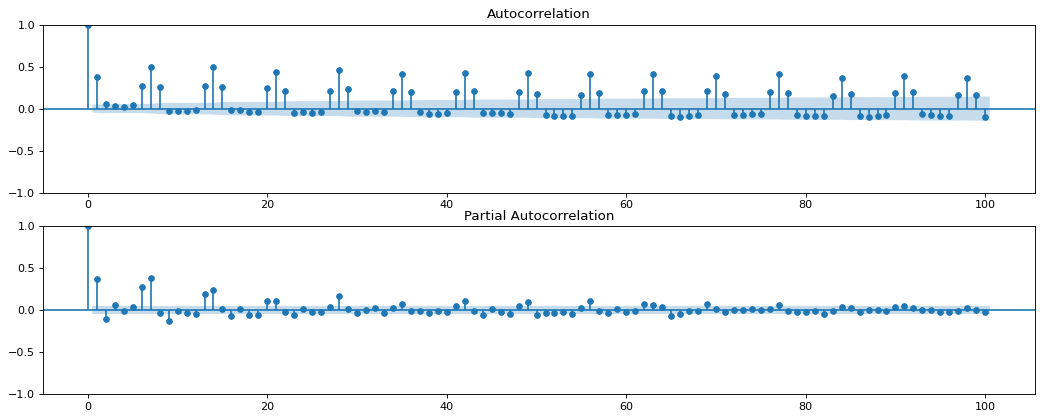

In [21]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,6), dpi= 80)
plot_acf(grocI44['sales'], ax=ax1, lags=100)
plot_pacf(grocI44['sales'], ax=ax2, lags=100);


There is a strong and obvious weekly seasonality to this data, judging by the correlation on lag 7 and future multiples of 7 - persistent 7-day spikes in the ACF.

Therefore, due to a percieved lack of stationarity, we will need to do some form of differencing.

"To distinguish seasonal differences from ordinary differences, we sometimes refer to ordinary differences as “first differences”, meaning differences at lag 1.

Sometimes it is necessary to take both a seasonal difference and a first difference to obtain stationary data. 

First differences are the change between one observation and the next. Seasonal differences are the change between one year to the next.

One way to determine more objectively whether differencing is required is to use a unit root test. These are statistical hypothesis tests of stationarity that are designed for determining whether differencing is required." []

https://otexts.com/fpp3/stationarity.html

#### 3.2 Augmented Dickey-Fuller

According to the statsmodels documentation [4], "The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation."

[4] https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

Null Hypothesis (H0): The time series has a unit root, meaning it is non-stationary. There exists a time dependent structure.

Alternate Hypothesis (H1): The time series does not have a unit root, meaning it is stationary. There is not a time-dependent structure.

p-value > 0.05: Accept the null hypothesis (H0), the data is not stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data is stationary.


In [8]:
adfuller(grocI44['sales'], autolag='AIC')

(-4.932996675785276,
 3.0067619507909915e-05,
 22,
 1665,
 {'1%': -3.434283579780684,
  '5%': -2.863277451883613,
  '10%': -2.5676949772294817},
 30980.030707750837)

Augmented Dickey Fuller test shows that there is stationarity in this time series, with a p-value of 0.00003. The test statistic of -4.93 is considerably below the 1% critical value of -3.43, therefore we can reject the null hypothesis with high confidence.

The intuition behind the test is that if the series is characterised by a unit root process then the lagged level of the series (y_{t-1}) will provide no relevant information in predicting the change in y_t besides the one obtained in the lagged changes (Δ y_{t − k}). In this case the null hypothesis of γ = 0 is rejected and no unit root is present.   [Wikipedia]


#### 3.3 KPSS stationarity test

In [9]:
kpss(grocI44['sales'], regression='c')

(4.715616782293408,
 0.01,
 11,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

KPSS test shows that there is *not* stationarity in this time series, with a p-value of 0.01 or less.The test statistic of 4.71 is considerably above the 1% critical value of 0.739, therefore we can reject the null hypothesis with high confidence.

The point of KPSS is to test the null hypothesis that an observable series is trend-stationary (stationary around a deterministic trend). The series is expressed as the sum of deterministic trend, random walk, and stationary error, and the test is the Lagrange multiplier test of the hypothesis that the random walk has zero variance. KPSS-type tests are intended to complement unit root tests, such as the Dickey–Fuller tests. By testing both the unit root hypothesis and the stationarity hypothesis, one can distinguish series that appear to be stationary, series that appear to have a unit root, and series for which the data (or the tests) are not sufficiently informative to be sure whether they are stationary or integrated.  [Wikipedia]


What we realize after performing each of these tests is that there is a contradictory-seeming conclusion over this series' stationarity (ADF implies that it is stationary, KPSS implies that it is not stationary).

#### 3.4 Stationarity function

Here is a function that can determine if the ADF and KPSS tests produce conflicting results, for future use.

In [99]:
def stationarity_testing(tsdf):
    
    dftest = adfuller(tsdf, autolag='AIC')
    df_p_val = dftest[1]
    kpss(tsdf, regression='c')
    kpss_p_val = kpss(tsdf, regression='c')[1]
    
    if df_p_val > 0.05:
        adf_det = "Not Stationary"
    else:
        adf_det = "Stationary"
    if kpss_p_val < 0.05:
        kpss_det = "Not Stationary"
    else:
        kpss_det = "Stationary"
        
    if adf_det == kpss_det:
        det = "not conflicting"
    else:
        det = "conflicting"
    
    
    print("ADF p value is {}\nKPSS p value is {}\n".format(df_p_val,kpss_p_val))
    print("ADF implies that the series is {}\nKPSS implies that the series is {}\n".format(adf_det,kpss_det))
    print("These test results are {}.".format(det))
    

Testing the Store 44 Grocery I sales data

In [101]:
stationarity_testing(grocI44['sales'])

ADF p value is 3.0067619507909915e-05
KPSS p value is 0.01

ADF implies that the series is Stationary
KPSS implies that the series is Not Stationary

These test results are conflicting.


***<u>If the ADF test does not find a unit root, but the KPSS test does, the series is difference-stationary: it requires differencing.</u>***

#### 3.5 Seasonal stationarity testing

We must determine the number of differences required for a seasonally stationary series.

"<br>
Osborn-Chui-Smith-Birchenhall OCSB Test:

    Null hypothesis: the series contains a seasonal unit root
    It uses a Dickey-Fuller type regression.

Canova-Hansen Test for Seasonal Stability:

    Null hypothesis: the seasonal pattern is stable over time
"

[]

https://towardsdatascience.com/when-a-time-series-only-quacks-like-a-duck-10de9e165e

In [102]:
from pmdarima.arima.utils import ndiffs
from pmdarima.arima import OCSBTest, CHTest

In [103]:
n_adf = ndiffs(grocI44['sales'], test = "adf")
n_kpss = ndiffs(grocI44['sales'], test = "kpss")
n_diffs = {"ADF ndiff":n_adf, "KPSS ndiff":n_kpss}
print("recommended order of first differencing for original data:")
[print(key, ":", value) for key,value in n_diffs.items()];

recommended order of first differencing for original data:
ADF ndiff : 0
KPSS ndiff : 1


In [105]:
# time series before first differencing
# OCSB test that returns the recommended order of seasonal differencing:
n_ocsb = OCSBTest(m=7, max_lag=7,lag_method='aicc').estimate_seasonal_differencing_term(grocI44['sales'])


# CH test that returns the recommended order of seasonal differencing:
n_ch = CHTest(m=7).estimate_seasonal_differencing_term(grocI44['sales'])


# seasonal differencing recommendation:
print("time series before first differencing -")
n_seasdiffs = {"recommended order of seasonal differencing":"", "OCSB recommendation":n_ocsb, "nCH recommendation":n_ch}
[print(key, ":", value) for key,value in n_seasdiffs.items()];

time series before first differencing -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 1


The OCSB does not identify a need for seasonal differencing, similar to the ACF for first differencing.
However, the CH test does recommend 1 order of seasonal differencing, similar to KPSS for first differencing.

Since we observed the data as having a strong weekly periodicity, and the frequency is daily, then we will use a differencing of 7 to remove seasonal effects, then retest.

In [106]:
# ADF and KPSS tests after first differencing AND seasonal differencing:
# use the larger recommended order of first and seasonal differencing, respectively

df_diff7 = grocI44['sales'].diff(7).dropna()


# after first AND seasonal differencing: compare ADF, KPSS, OCSB and CH results
n_adf7 = ndiffs(df_diff7, test="adf")
n_kpss7 = ndiffs(df_diff7, test="kpss")
n_ocsb7 = OCSBTest(m=7, max_lag=7,lag_method='aicc').estimate_seasonal_differencing_term(df_diff7)
n_ch7 = CHTest(m=7).estimate_seasonal_differencing_term(df_diff7)

print("after 1 round of differencing - do we need more?")
n_diffs = {"recommended additional differencing":"", "ADF first":n_adf7, "KPSS first":n_kpss7, 
    "OCSB seasonal":n_ocsb7, "CH seasonal":n_ch7}
[print(key, ":", value) for key,value in n_diffs.items()];


after 1 round of differencing - do we need more?
recommended additional differencing : 
ADF first : 0
KPSS first : 0
OCSB seasonal : 0
CH seasonal : 0


This is excellent, as all four of our tests imply that this 7-day seasonal differencing is sufficient to make the series stationary.

According to Hyndman, "If the data have a strong seasonal pattern, we recommend that seasonal differencing be done first, because the resulting series will sometimes be stationary and there will be no need for a further first difference. If first differencing is done first, there will still be seasonality present.

Beware that applying more differences than required will induce false dynamics or autocorrelations that do not really exist in the time series. Therefore, do as few differences as necessary to obtain a stationary series."

Therefore, after differencing for the weekly seasonality and finding it sufficient, we will forego first-order differencing at this time.

#### 3.6 Seasonally decomposition

We will visualize the decomposed series with one 7-day differencing applied.

https://medium.com/geekculture/time-series-analysis-using-arima-model-with-python-afe4b41bbec8

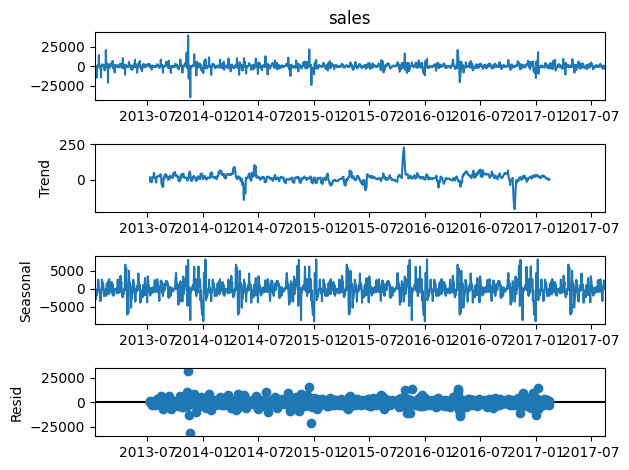

In [113]:
result = seasonal_decompose(grocI44['sales'].diff(7).dropna(),model='additive',period=365)

# Plot the original data, the trend, the seasonality, and the residuals 
result.plot();

While it appears that there is more seasonality to investigate (probably yearly and possibly monthly), we will temporarily move forward with creating our base model.

#### 3.6 ACF and PACF on stationary data

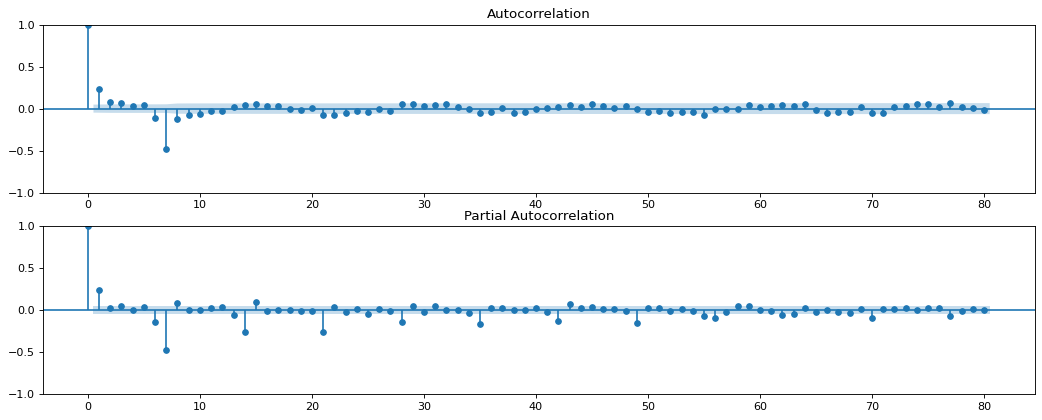

In [118]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,6), dpi= 80)
plot_acf(grocI44['sales'].diff(7).dropna(), ax=ax1, lags=80)
plot_pacf(grocI44['sales'].diff(7).dropna(), ax=ax2, lags=80);


The pattern is still visible, but the plots show quick loss of correlation with increasing lags.

How to interpret ACF and PACF plots

Time series models you’ll soon learn about, such as Auto Regression (AR), Moving Averages (MA), or their combinations (ARMA), require you to specify one or more parameters. These can be obtained by looking at ACF and PACF plots.

In a nutshell:

    If the ACF plot declines gradually and the PACF drops instantly, use Auto Regressive model.
    If the ACF plot drops instantly and the PACF declines gradually, use Moving Average model.
    If both ACF and PACF decline gradually, combine Auto Regressive and Moving Average models (ARMA).
    If both ACF and PACF drop instantly (no significant lags), it’s likely you won’t be able to model the time series.

https://towardsdatascience.com/time-series-from-scratch-autocorrelation-and-partial-autocorrelation-explained-1dd641e3076f

My initial inclination is to use a combination of Auto Regressive and Moving Average models.

#### 4.0 Baseline ARIMA

Based on the ACF and PACF, our baseline model will be a seasonal ARIMA with the order (1,0,1), with seasonal order being (0,1,1,7) to account for the weekly seasonality.

In [231]:
model = SARIMAX(grocI44['sales'], order=(1,0,1),seasonal_order=(0,1,1,7))
model_fit = model.fit()
print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                 1688
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood              -15584.393
Date:                           Tue, 04 Apr 2023   AIC                          31176.787
Time:                                   15:53:22   BIC                          31198.495
Sample:                               01-01-2013   HQIC                         31184.828
                                    - 08-15-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8763      0.019     45.046      0.000       0.838       0.914
ma.L1         -0.6673      0.024    -27.941

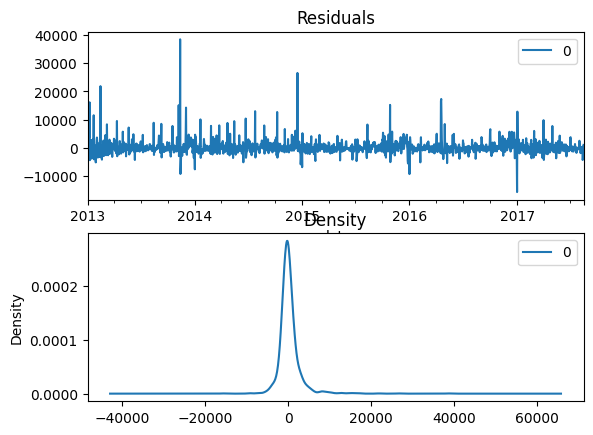

In [232]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(2,1)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show();

In [233]:
sarima_pred = model_fit.predict(start='2017-08-01',end='2017-08-31')

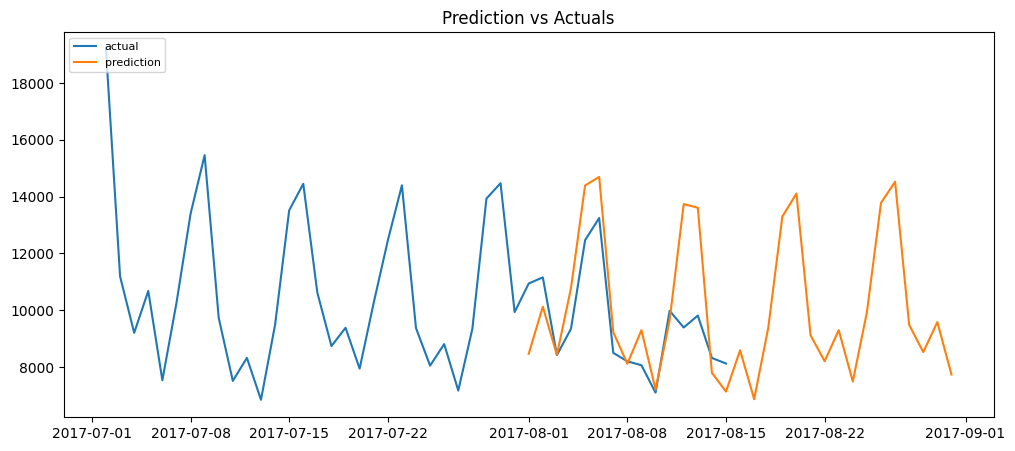

In [240]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(grocI44[grocI44.index>'2017-07-01']['sales'], label='actual')
plt.plot(sarima_pred, label='prediction')
plt.title('Prediction vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [243]:
# Create Training and Test
train = grocI44.iloc[:-30]['sales']
test = grocI44.iloc[-30:]['sales']

# Build Model
model = SARIMAX(train, order=(1,0,1),seasonal_order=(0,1,1,7)) 
fitted = model.fit()  

# Forecast
fc = fitted.get_forecast(30, alpha=0.05)  # 95% conf

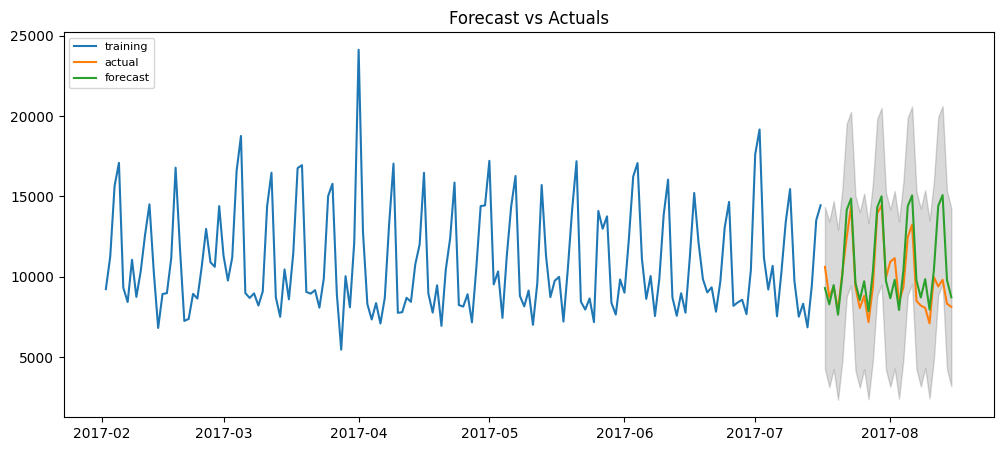

In [244]:
# Make as pandas series
lower_series = fc.conf_int(alpha=0.05).iloc[:,0]
upper_series = fc.conf_int(alpha=0.05).iloc[:,1]

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[train.index>'2017-02-01'], label='training')
plt.plot(test, label='actual')
plt.plot(fc.predicted_mean, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

The forecast appears to be quite accurate for the limited timeframe we are testing. However, due to the unaccounted for monthly and yearly seasonality, the results will unlikely be accurate over a longer term.

If we predict into the end of the year, where there is a known significant annual uptick in sales, the predictive power will appear more limited.

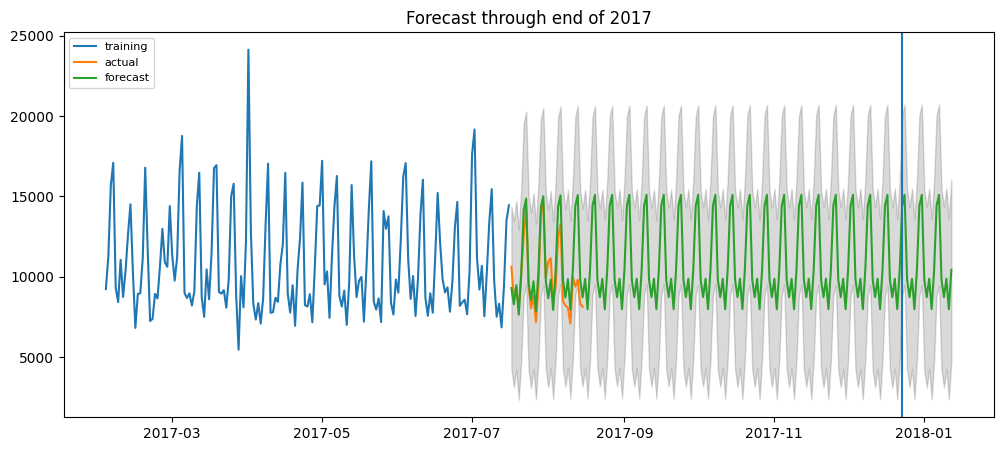

In [267]:
fc2 = fitted.get_forecast(180, alpha=0.05)  # 95% conf
# Make as pandas series
lower_series = fc2.conf_int(alpha=0.05).iloc[:,0]
upper_series = fc2.conf_int(alpha=0.05).iloc[:,1]

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[train.index>'2017-02-01'], label='training')
plt.plot(test, label='actual')
plt.plot(fc2.predicted_mean, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.axvline(x = pd.to_datetime('2017-12-23'))
plt.title('Forecast through end of 2017')
plt.legend(loc='upper left', fontsize=8)
plt.show()

The pattern of the predicted sales remains fairly constant no matter the length of the prediction window. Highlighted is the approximate time that we would expect to see the significant end-of-year sales increase.

In [245]:
pred = fitted.predict(start=min(test.index),end=max(test.index))

In [246]:
pred

2017-07-17     9294.982887
2017-07-18     8279.042867
2017-07-19     9478.924037
2017-07-20     7634.426261
2017-07-21    10125.582602
2017-07-22    14160.846964
2017-07-23    14867.963117
2017-07-24     9607.914355
2017-07-25     8552.946041
2017-07-26     9718.666461
2017-07-27     7844.268408
2017-07-28    10309.253583
2017-07-29    14321.610805
2017-07-30    15008.676759
2017-07-31     9731.078425
2017-08-01     8660.749292
2017-08-02     9813.024669
2017-08-03     7926.858417
2017-08-04    10381.543103
2017-08-05    14384.884496
2017-08-06    15064.059060
2017-08-07     9779.553537
2017-08-08     8703.178669
2017-08-09     9850.162324
2017-08-10     7959.364325
2017-08-11    10409.994929
2017-08-12    14409.787857
2017-08-13    15085.856515
2017-08-14     9798.632449
2017-08-15     8719.878091
Freq: D, Name: predicted_mean, dtype: float64

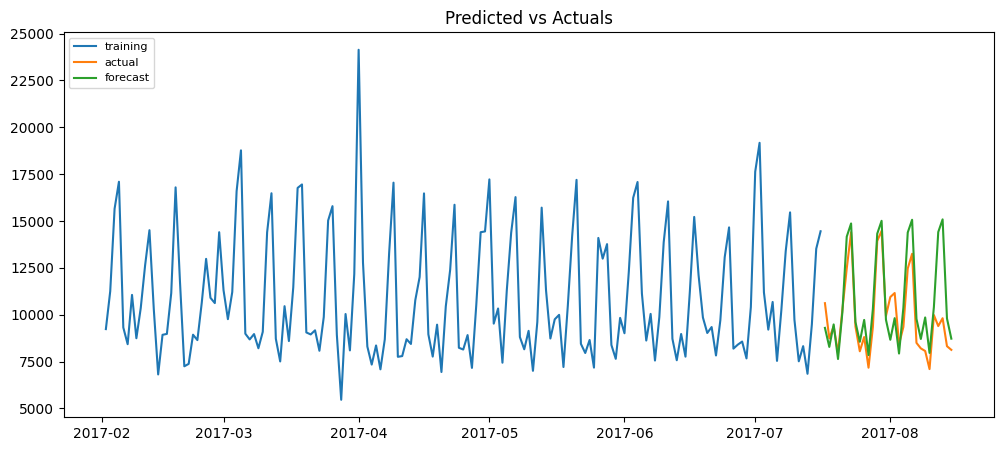

In [268]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[train.index>'2017-02-01'], label='training')
plt.plot(test, label='actual')
plt.plot(pred, label='forecast')
plt.title('Predicted vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [269]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit

In [270]:
data = grocI44['sales']
tss = TimeSeriesSplit()
X_tr = []
X_te = []
y_tr = []
y_te = []

#X_train, y_train = tss.split(data)
for fold, (train_index, test_index) in enumerate(tss.split(data)):
    print("Fold: {}".format(fold))
    print("TRAIN indices:", min(train_index)," ... ",max(train_index), "\n",
          "TEST indices:", min(test_index)," ... ",max(test_index))
    print("\n")
    X_tr.append(data[train_index])
    X_te.append(data[test_index])
    y_tr.append(data[train_index])
    y_te.append(data[test_index])

Fold: 0
TRAIN indices: 0  ...  282 
 TEST indices: 283  ...  563


Fold: 1
TRAIN indices: 0  ...  563 
 TEST indices: 564  ...  844


Fold: 2
TRAIN indices: 0  ...  844 
 TEST indices: 845  ...  1125


Fold: 3
TRAIN indices: 0  ...  1125 
 TEST indices: 1126  ...  1406


Fold: 4
TRAIN indices: 0  ...  1406 
 TEST indices: 1407  ...  1687




In [271]:
X_tr[0]

date
2013-01-01        0.0
2013-01-02    10686.0
2013-01-03     7342.0
2013-01-04     7250.0
2013-01-05    10699.0
               ...   
2013-10-06    13168.0
2013-10-07     7334.0
2013-10-08     5696.0
2013-10-09     6973.0
2013-10-10     4947.0
Name: sales, Length: 283, dtype: float64

In [272]:
my_order = (1, 0, 1)
my_seasonal_order = (0, 1, 1, 7)
# define model
model0 = SARIMAX(X_tr[0], order=my_order, seasonal_order=my_seasonal_order)

In [273]:

# fit model
model_fit0 = model0.fit()

yhat0 = model_fit0.forecast(len(X_te[0]))

In [274]:
yhat0

2013-10-11     6311.500869
2013-10-12    10024.330538
2013-10-13    10932.978790
2013-10-14     7363.242677
2013-10-15     6313.736981
                  ...     
2014-07-14     7413.327262
2014-07-15     6348.481390
2014-07-16     7690.891966
2014-07-17     5868.359230
2014-07-18     6461.525138
Freq: D, Name: predicted_mean, Length: 281, dtype: float64

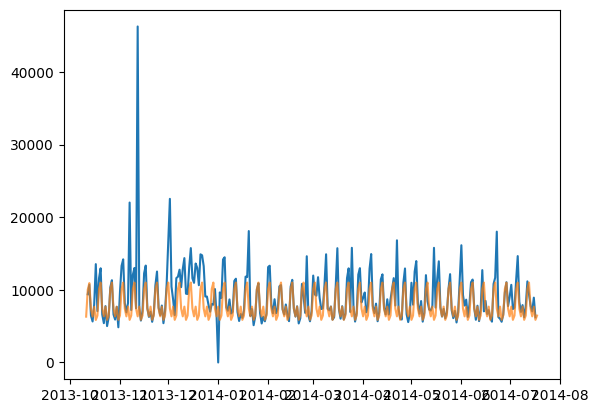

In [275]:
plt.plot(data[(data.index>min(yhat0.index))&(data.index<max(yhat0.index))])
plt.plot(yhat0,alpha=0.7)
plt.show()

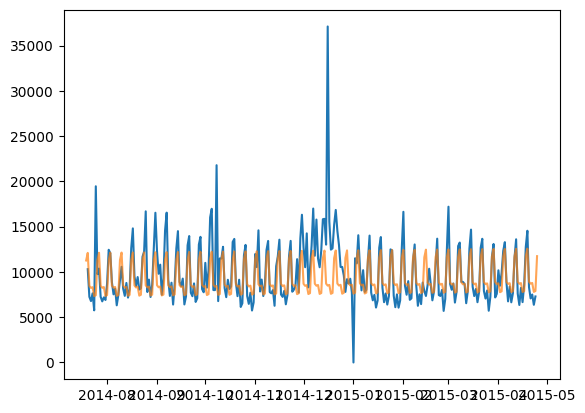

In [276]:
my_order = (1, 0, 1)
my_seasonal_order = (0, 1, 1, 7)
# define model
model1 = SARIMAX(X_tr[1], order=my_order, seasonal_order=my_seasonal_order)
# fit model
model_fit1 = model1.fit()

yhat1 = model_fit1.forecast(len(X_te[1]))
plt.plot(data[(data.index>min(yhat1.index))&(data.index<max(yhat1.index))])
plt.plot(yhat1,alpha=0.7)


plt.show()

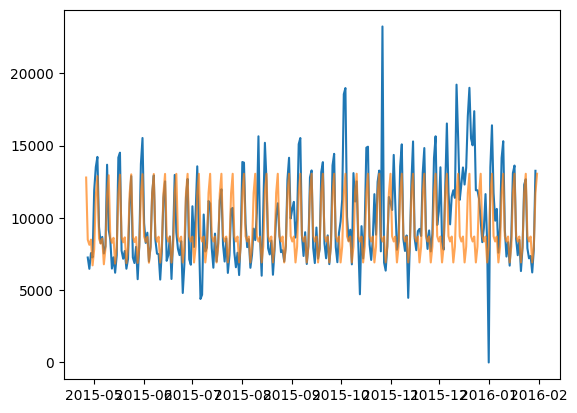

In [279]:
my_order = (1, 0, 1)
my_seasonal_order = (0, 1, 1, 7)
# define model
model2 = SARIMAX(X_tr[2], order=my_order, seasonal_order=my_seasonal_order)
# fit model
model_fit2 = model2.fit()

yhat2 = model_fit2.predict(start=min(X_te[2].index), end=max(X_te[2].index))
plt.plot(data[(data.index>min(yhat2.index))&(data.index<max(yhat2.index))])
plt.plot(yhat2,alpha=0.7)


plt.show()

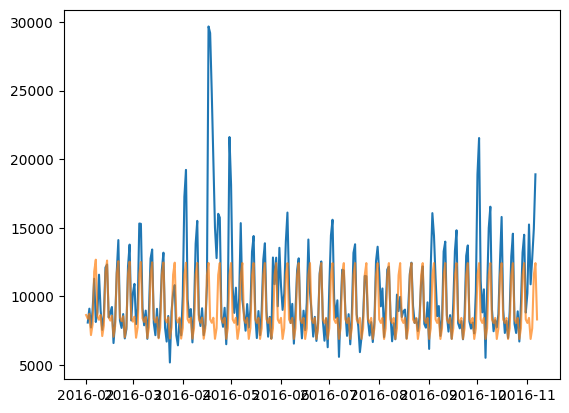

In [278]:
my_order = (1, 0, 1)
my_seasonal_order = (0, 1, 1, 7)
# define model
model3 = SARIMAX(X_tr[3], order=my_order, seasonal_order=my_seasonal_order)
# fit model
model_fit3 = model3.fit()

yhat3 = model_fit3.predict(start=min(X_te[3].index), end=max(X_te[3].index))
plt.plot(data[(data.index>min(yhat3.index))&(data.index<max(yhat3.index))])
plt.plot(yhat3,alpha=0.7)


plt.show()

In [309]:
periods = [7,14,30,365]

mstl = MSTL(X_tr[3], periods=periods)
res = mstl.fit()

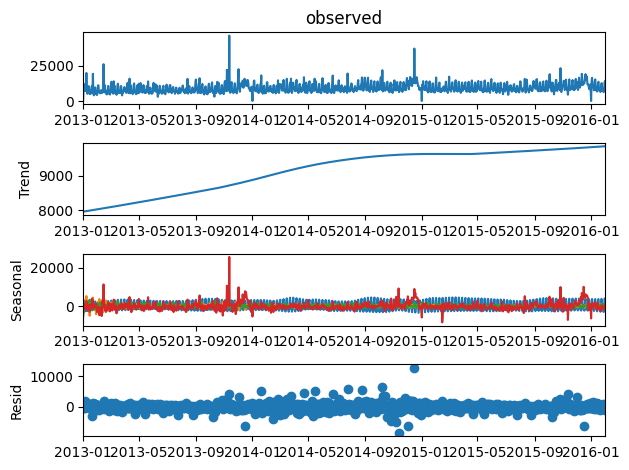

In [310]:
res.plot()
plt.tight_layout()
plt.show()

Since the graph is small and complex, we can break down the different 'Seasonal' plots into individual visualizations

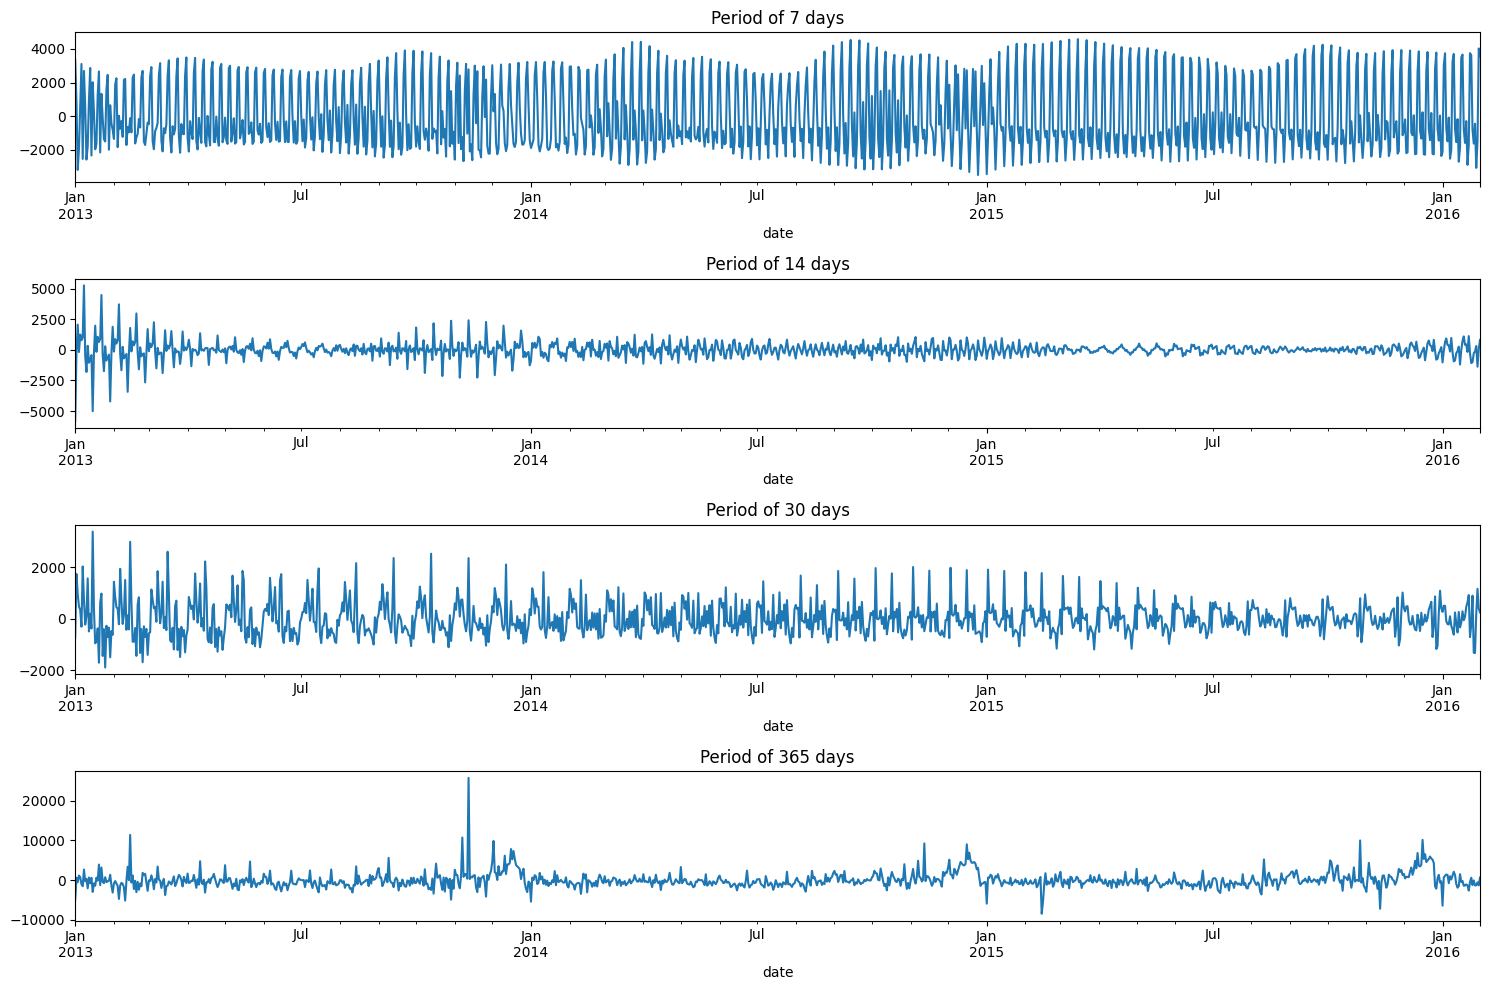

In [312]:
fig, ax = plt.subplots(4,1,figsize=(15, 10))
for e,i in enumerate(res.seasonal.columns):
    res.seasonal[i].plot(title="Period of {} days".format(periods[e]),ax=ax[e])
fig.tight_layout()
plt.show();

In [313]:
seasonal_res = res.seasonal
seasonal_res

,seasonal_7,seasonal_14,seasonal_30,seasonal_365
date,,,,
2013-01-01,3341.657446,-5834.578657,-731.759161,-4902.050258
2013-01-02,872.097948,-235.945418,1730.947582,601.536785
2013-01-03,-3200.720051,2056.072979,950.281918,-559.634585
2013-01-04,-1910.465645,-182.717227,468.191449,1137.868522
2013-01-05,679.713938,1247.338117,335.192448,729.600639
...,...,...,...,...
2016-01-27,-451.954498,-136.499766,-1339.442774,-1342.881920
2016-01-28,-3079.319233,307.028288,190.304758,-1316.029847
2016-01-29,-1498.502044,-1379.008094,1155.171008,-544.366582


AttributeError: 'DecomposeResult' object has no attribute 'predict'

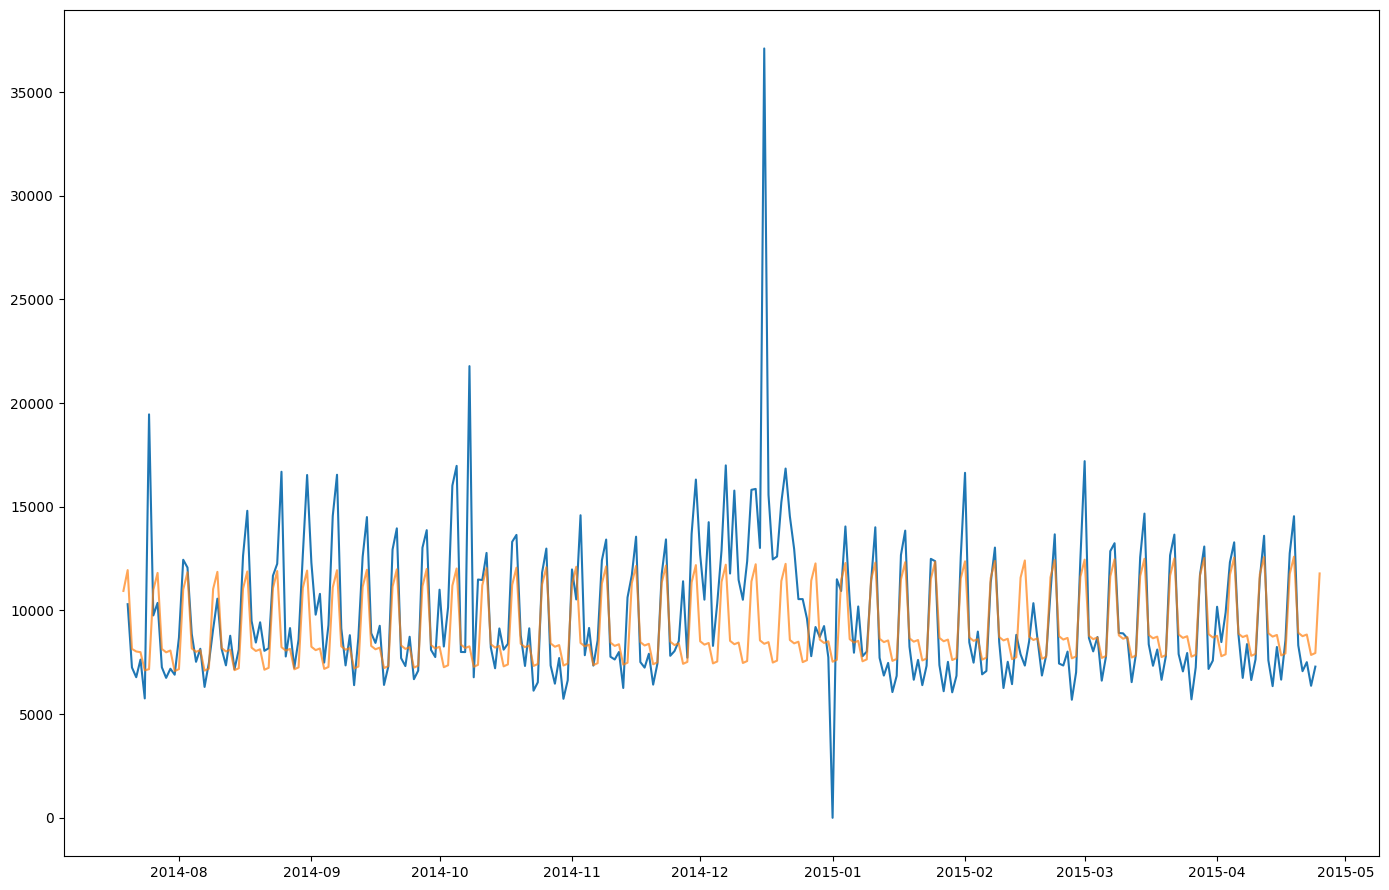

In [321]:
yhat1p = model_fit1p.predict(start=min(X_te[1].index), end=max(X_te[1].index))
figure(figsize=(14,9), dpi=100)
plt.plot(data[(data.index>min(yhat1p.index))&(data.index<max(yhat1p.index))])
plt.plot(yhat1p,alpha=0.7)

plt.tight_layout()
plt.show()

In [58]:
from datetime import datetime, timedelta

In [38]:
from sktime.forecasting.tbats import TBATS

In [315]:
forecaster = TBATS(use_box_cox=True,
                  use_trend=False,
                  use_damped_trend=False,
                  sp=[7,30,365])

In [316]:
forecaster.fit(X_tr[3])

TBATS(sp=[7, 30, 365], use_box_cox=True, use_damped_trend=False,
      use_trend=False)

In [327]:
y_pred_TBATS = forecaster.predict(pd.date_range(start=min(X_te[3].index), periods=len(X_te[3]), freq='D'))

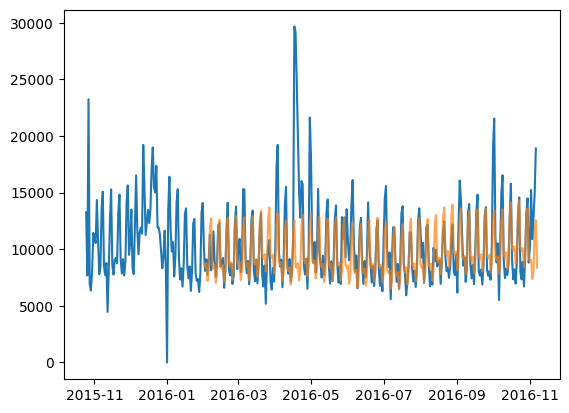

In [328]:
plt.plot(data[(data.index>min(y_pred_TBATS.index)-timedelta(days=100))&(data.index<max(y_pred_TBATS.index))],label="Original")
plt.plot(y_pred_TBATS,alpha=0.7,label="predicted")


plt.show()

In [332]:
len(X_te[3])

281

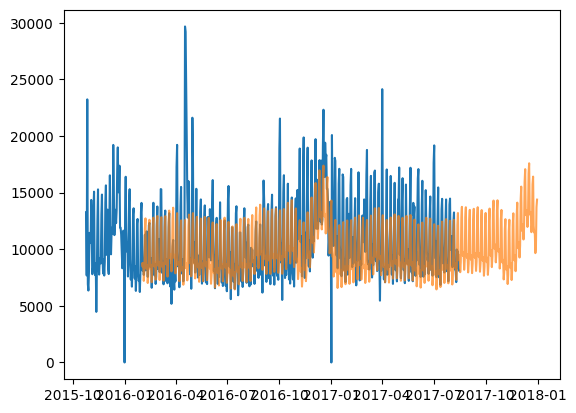

In [339]:
y_pred_TBATS2 = forecaster.predict(pd.date_range(start=min(X_te[3].index), periods=700, freq='D'))
plt.plot(data[(data.index>min(y_pred_TBATS2.index)-timedelta(days=100))&(data.index<max(y_pred_TBATS2.index))],label="Original")
plt.plot(y_pred_TBATS2,alpha=0.7,label="predicted")


plt.show()

#### 2.3 Adjust elements of the data for EDA suitability<a id='2.3'></a>

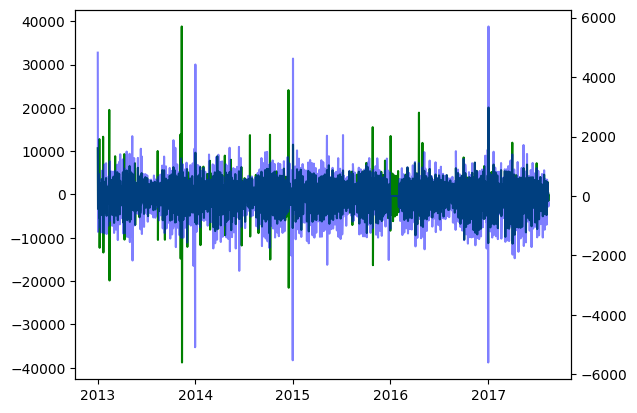

In [7]:
#figure(figsize=(14,9), dpi=100)
fig,ax = plt.subplots()

ax.plot(grocI44['sales'].diff(),color='g')
ax2=ax.twinx()
ax2.plot(grocI44['transactions'].diff(),color='b',alpha=0.5)
plt.xlabel('time')
plt.show()

### 7.0 Output and Summary<a id='7.0'></a>

In this notebook, we imported the conglomerated, wrangled, and cleaned Favorita data. Then we inspected how a time series looked. Upon discovering an issue of missing data immediately, we created a function to resolve the issue and impute the missing data everywhere possible. Then we filled in whatever gaps existed.

Once the data was ready to have its characteristics visualized, we explored sales data by year, month, and day, noting obvious patterns (such as the year-end and month-end peak which occur). We also saw how sales were distributed by category for store, product family, city, state, cluster, and store type.

Next, we visualized non-sales data and how it behaved across different time epochs. Oil price and transaction data were then analyzed on their correlation with sales and each other. 

Finally, we worked on decomposing the time series. Initially, we ran an Augmented Dickey-Fuller test on one time series to determine stationarity, then we created a function that tested each of the 1782 time series in our data. The outcome was that ~71% of the data is stationary. We visualized the elements of one time series as a result of seasonally decomposing it, and output the final data to csv for modeling.